In [1]:
import datetime
import time
import uuid

import numpy as np
# package(s) for data handling
import pandas as pd
import shapely.geometry
import simpy

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {"key": "MultiStoreHopper"},
)

In [3]:
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    initials=[
        {"id": "MP", "level": 10, "capacity": 10},
    ],
)
to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID=str(uuid.uuid4()),
    geometry=location_to_site,
    store_capacity=4,
    nr_resources=1,
    initials=[
        {"id": "MP", "level": 0, "capacity": 10},
    ],
)

In [4]:
vessel_1 = TransportProcessingResource(
    env=my_env,
    name="Vessel 01",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
    ],
)
vessel_2 = TransportProcessingResource(
    env=my_env,
    name="Vessel 02",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
    ],
)

installer = TransportProcessingResource(
    env=my_env,
    name="Installer",
    ID=str(uuid.uuid4()),
    geometry=location_to_site,
    store_capacity=4,
    nr_resources=1,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
    ],
)

In [5]:

processes = []
for i, vessel in enumerate([vessel_1,vessel_2]):
    requested_resources1 = {}
    processes.append(
        model.RepeatActivity(
            env=my_env,
            name=f"while {vessel.name}",
            ID=str(uuid.uuid4()),
            registry=registry,
            sub_processes=[
                model.SequentialActivity(
                    env=my_env,
                    name=f"sequence {vessel.name}",
                    ID=str(uuid.uuid4()),
                    registry=registry,
                    sub_processes=[
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing empty {vessel.name}",
                            ID=str(uuid.uuid4()),
                            registry=registry,
                            mover=vessel,
                            destination=from_site,
                            duration=10,
                            requested_resources=requested_resources1,
                        ),
                        model.ShiftAmountActivity(
                            env=my_env,
                            name=f"Load MP {vessel.name}",
                            ID=str(uuid.uuid4()),
                            registry=registry,
                            processor=vessel,
                            origin=from_site,
                            destination=vessel,
                            amount=1,
                            duration=10,
                            id_="MP",
                            requested_resources=requested_resources1,
                        ),
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing filled {vessel.name}",
                            ID=str(uuid.uuid4()),
                            registry=registry,
                            mover=vessel,
                            destination=to_site,
                            duration=10,
                            requested_resources=requested_resources1,
                        ),
                        model.ShiftAmountActivity(
                            env=my_env,
                            name=f"Transfer MP {vessel.name}",
                            ID=str(uuid.uuid4()),
                            registry=registry,
                            processor=installer,
                            origin=vessel,
                            destination=installer,
                            amount=1,
                            duration=10,
                            id_="MP",
                            requested_resources=requested_resources1,
                            start_event={"type": "container","concept": installer,"state": "empty", "id_":"MP"}
                        ),
                    ],
                )
            ],
            repetitions=5
        )
    )

In [6]:
install_process = model.WhileActivity(
    env=my_env,
    name=f"While installer",
    ID=str(uuid.uuid4()),
    registry=registry,
    condition_event={"type": "container","concept": to_site,"state": "full", "id_":"MP"},
    sub_processes=[
        model.ShiftAmountActivity(
            env=my_env,
            name=f"Install MP",
            ID=str(uuid.uuid4()),
            registry=registry,
            processor=installer,
            origin=installer,
            destination=to_site,
            amount=1,
            duration=10,
            id_="MP",
#             start_event={"type": "container","concept": installer,"state": "full", "id_":"MP"}
            start_event={"or":[
                {"type": "container","concept": installer,"state": "full", "id_":"MP"},
                {"type":"activity", "name":"Transfer MP Vessel 01", "state":"done"},
                {"type":"activity", "name":"Transfer MP Vessel 02", "state":"done"},
            ]}
        )
    ],
)

In [7]:
model.register_processes([
    install_process, 
    *processes
])
my_env.run()

Installer 0
Installer 0
Installer 0
Installer 1


ValueError: A valid container reservation could not be made. Tried 100 times

In [8]:
acts = []
for proc in processes:
    acts.extend(proc.sub_processes[0].sub_processes)
    
plot.vessel_planning([
    *install_process.sub_processes,
    *acts
])

KeyError: 'container level'

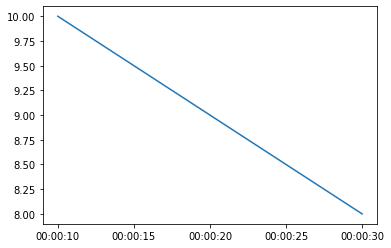

In [9]:
fig = plot.get_step_chart([from_site, to_site])

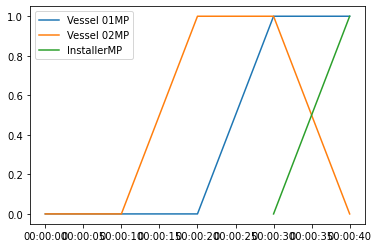

In [10]:
fig = plot.get_step_chart([vessel_1,vessel_2, installer])

In [11]:
pd.DataFrame(install_process.log)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01,09839118-231f-451a-942c-88753dd64f0a,START,{},{}
1,1970-01-01,09839118-231f-451a-942c-88753dd64f0a,START,{},"{'type': 'subprocess', 'ref': '5fd6232e-e5a4-4..."


In [12]:
pd.DataFrame(install_process.sub_processes[0].log)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01 00:00:00,5fd6232e-e5a4-420e-9432-2d3588eb2622,WAIT_START,{},{}
1,1970-01-01 00:00:40,5fd6232e-e5a4-420e-9432-2d3588eb2622,WAIT_STOP,{},{}
